# Sentiment Analysis on Tweets

In this project, we will tackle a Sentiment Analysis task, which involves automatically classifying tweets into three categories:
- **Positive**
- **Negative**
- **Neutral**

The goal is to build a **classifier** capable of predicting the sentiment of a tweet, starting from a labeled dataset.

The project will be divided into the following phases:
1. **Dataset exploration** to understand the class distribution and data quality.
2. **Text preprocessing** to remove noise and obtain a clean representation.
3. **Exploratory analysis** of the most frequent words for each class.
4. **Transformation of texts into numerical features** using the TF-IDF technique.
5. **Training of Machine Learning models**
6. **Performance evaluation** using classification metrics and confusion matrix.

# 1. Loading the data
We loaded the dataset using the pandas library and displayed the first rows of the dataset.

In [20]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Load the dataset
df = pd.read_csv('Tweets.csv', encoding='utf-8')


# Display the first rows of the dataset
df.head()

,tweet,sentiment
0,The event starts at 5 PM.,neutral
1,I hate how this turned out.,negative
2,Fantastic experience!,positive
3,This is the worst thing ever!,negative
4,What a wonderful day!,positive


# 2. First inspection of the dataset

In [21]:
# Dataset dimensions
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Check the column names
print("Column names:", df.columns.tolist())

The dataset contains 20947 rows and 2 columns.
Column names: ['tweet', 'sentiment']


In [22]:
# Print all possible unique values for the 'sentiment' column
print("Unique values in the 'sentiment' column:", df['sentiment'].unique())

Unique values in the 'sentiment' column: ['neutral' 'negative' 'positive']



Null values per column:
tweet           0
sentiment       0
cleaned_text    0
label           0
dtype: int64

Label distribution:
sentiment
neutral     8568
positive    6401
negative    5978
Name: count, dtype: int64


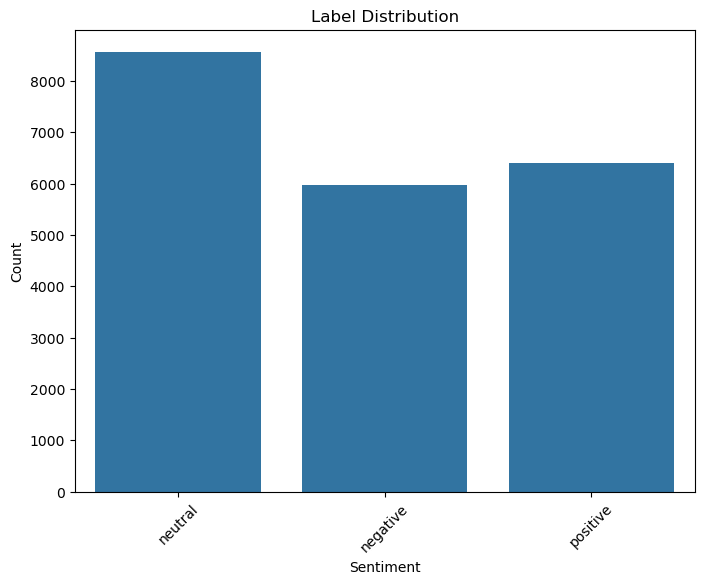

In [51]:
# Check for null values
print("\nNull values per column:")
print(df.isnull().sum())

# Check the label distribution
print("\nLabel distribution:")
print(df['sentiment'].value_counts())

# Create a histogram to see the label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Average tweet length per sentiment:
sentiment
negative    12.450151
neutral     11.154295
positive    12.055304
Name: length, dtype: float64


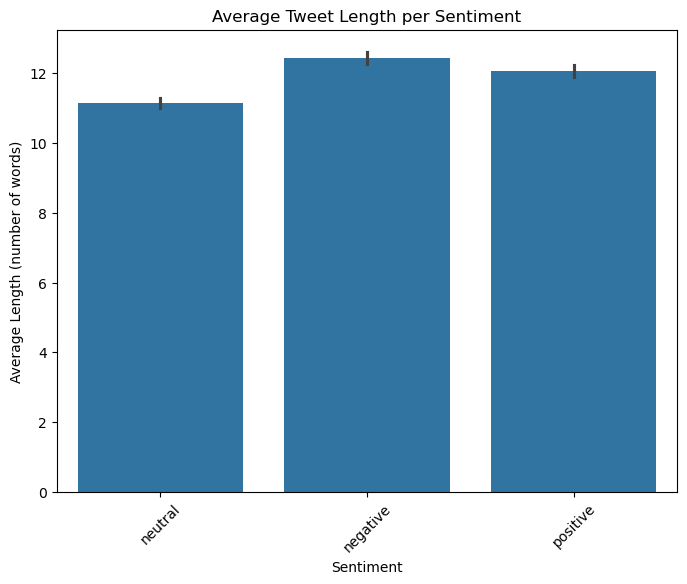

In [52]:
# Print the average length of tweets per sentiment
print("\nAverage tweet length per sentiment:")
df['length'] = df['tweet'].apply(lambda x: len(x.split()))   
print(df.groupby('sentiment')['length'].mean())

# Visualize the average tweet length per sentiment
plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment', y='length', data=df)
plt.title('Average Tweet Length per Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Length (number of words)')
plt.xticks(rotation=45)
plt.show()

# 3. Tweet Preprocessing

In [23]:
import re
import emoji
    
def clean_text(text, keep_emojis=True):
    if pd.isna(text):
        return ""

    text = text.lower()  # case normalization
    
    # Remove URLs, mentions and hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove mentions and hashtags, considering that some might be written with a space between @ and the name
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Handle repeated characters (sooooo -> so)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    # Remove special characters but keep letters, numbers, spaces and underscore
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove single characters EXCEPT "i" and "a" which are important
    text = re.sub(r'\b(?![ia]\b)\w\b', '', text)

    # If you want to keep emojis
    if keep_emojis:
        text = emoji.demojize(text, language='en')
        text = re.sub(r':', ' ', text)
        text = re.sub(r'[^\w\s]', '', text)
    else:
        text = emoji.replace_emoji(text, replace='')
        text = re.sub(r'[^\w\s]', '', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [24]:
# Apply the cleaning function to the dataset text
df['cleaned_text'] = df['tweet'].apply(clean_text)
df.head()

,tweet,sentiment,cleaned_text
0,The event starts at 5 PM.,neutral,the event starts at pm
1,I hate how this turned out.,negative,i hate how this turned out
2,Fantastic experience!,positive,fantastic experience
3,This is the worst thing ever!,negative,this is the worst thing ever
4,What a wonderful day!,positive,what a wonderful day


## 3.1 Label Encoder

In [25]:
# Map labels to numbers
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

In [26]:
# Print original labels and corresponding numerical values
print("\nOriginal and encoded labels:")
for original, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"{original} -> {encoded}")
    

# Distribution of numerical labels
print("\nDistribution of encoded labels:")
print(df['label'].value_counts())


Original and encoded labels:
negative -> 0
neutral -> 1
positive -> 2

Distribution of encoded labels:
label
1    8568
2    6401
0    5978
Name: count, dtype: int64


# 4 Visual Analysis of WordClouds for each Sentiment

WordClouds offer a graphical representation of the most frequent words in each sentiment class, helping us identify the most representative terms of the language used by users in tweets.

- **"neutral" Class**  
  The most common words are related to daily activities or informative content, such as "working", "home", "event starts", "today". No particular emotions or judgments emerge, which is consistent with a neutral tone.

- **"negative" Class**  
  In this class, words with negative connotations emerge such as "disappointed", "hate", "worst", "terrible decision", "sick". These terms clearly express feelings of dissatisfaction or discomfort, making the message tone easily recognizable as negative.

- **"positive" Class**  
  The WordCloud of positive tweets highlights words such as "loved", "happy", "fantastic experience", "great job", "wonderful day". These are all terms that convey positive emotions, gratitude or satisfaction, perfectly in line with the class label.

In [27]:
# Brief exploratory analysis of the most common words and word clouds of the classes
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    """Generate and display a word cloud"""
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

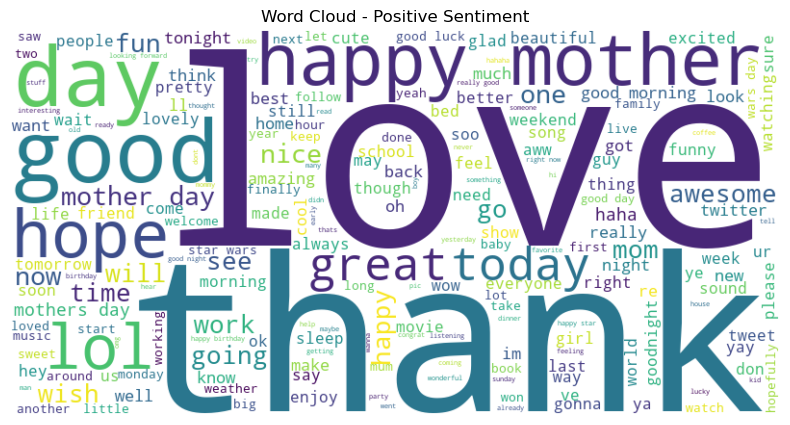

In [28]:
plot_wordcloud(" ".join(df[df['sentiment'] == 'positive']['cleaned_text']), "Word Cloud - Positive Sentiment")

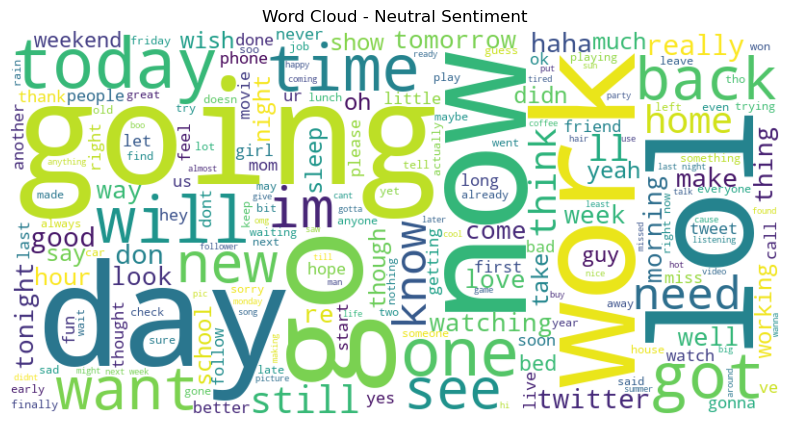

In [29]:
plot_wordcloud(" ".join(df[df['sentiment'] == 'neutral']['cleaned_text']), "Word Cloud - Neutral Sentiment")

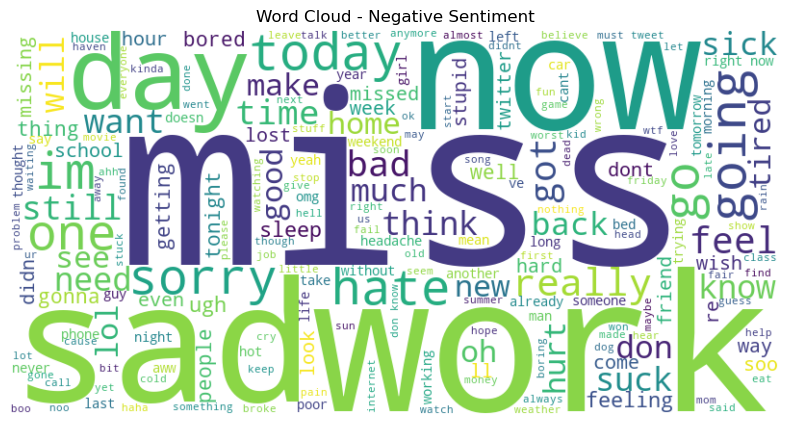

In [30]:
plot_wordcloud(" ".join(df[df['sentiment'] == 'negative']['cleaned_text']), "Word Cloud - Negative Sentiment")

# 5. Splitting the dataset into Training and Test Set

Before building the TF-IDF matrix, we split the dataset into two parts:
- **Training Set** (80% of the data), which we will use to train the model.
- **Test Set** (20% of the data), which we will use to evaluate its performance.

In [31]:
# Import the method for train/test split
from sklearn.model_selection import train_test_split
import numpy as np

# Define X and Y 
X = df['cleaned_text']
Y = df['label']

# Split into train and test maintaining the same class distribution (stratify=y)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.20, stratify=Y, random_state=4
)

# Verify dimensions
print(f"Training Set: {X_train.shape[0]} examples")
print(f"Test Set: {X_test.shape[0]} examples")

Training Set: 16757 examples
Test Set: 4190 examples


In [32]:
# Check the label distribution after splitting
print("\nLabel distribution in the training set:")
print(Y_train.value_counts())


Label distribution in the training set:
label
1    6854
2    5121
0    4782
Name: count, dtype: int64


## 5.1 Data Augmentation

In [33]:
import nlpaug.augmenter.word as naw

augmenter = naw.SynonymAug(aug_src='wordnet', lang='eng', aug_p=0.3)


import nltk

# Download required NLTK data for text augmentation
print("Downloading required NLTK packages...")
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("Download completed!")

Download completed!


In [34]:
import tqdm
import pandas as pd

def balance_classes_split(x_train, y_train, target_class, n_samples, le, seed=1234):
    """ 
    Balance classes by applying data augmentation on already separated X and y
    
    Args:
        X_train: Series with texts
        y_train: Series with encoded labels
        target_class: class to balance (encoded label, e.g.: 0, 1, 2)
        n_samples: target number of samples per class
        le: LabelEncoder already fitted
        seed: seed for reproducibility
    """
    np.random.seed(seed)
    
    # Find indices of target class
    target_indices = np.where(y_train == target_class)[0]
    
    # If the number of samples of the target class is already sufficient, return original data
    if len(target_indices) >= n_samples:
        return x_train, y_train
    
    n_to_generate = n_samples - len(target_indices)
    
    # Calculate weights based on text length
    target_texts = x_train.iloc[target_indices]
    text_lengths = target_texts.str.len()
    weights = text_lengths / text_lengths.sum()
    
    # Generate sample indices
    sample_indices = np.random.choice(target_indices, size=n_to_generate, p=weights)
    
    # Lists for new data
    synthetic_texts = []
    synthetic_labels = []
    
    # Apply data augmentation
    class_name = le.inverse_transform([target_class])[0]
    for sample_idx in tqdm.tqdm(sample_indices, desc=f"Augmenting {class_name}"):
        text = x_train.iloc[sample_idx]
        
        try:
            aug_text = str(augmenter.augment(text))
            
            # Quality checks
            if aug_text and aug_text != text and len(aug_text.split()) > 2:
                synthetic_texts.append(aug_text)
                synthetic_labels.append(target_class)
        except Exception as e:
            print(f"Augmentation failed for: {text[:50]}... Error: {e}")
            synthetic_texts.append(text)
            synthetic_labels.append(target_class)
    
    # Create synthetic DataFrame
    x_combined = pd.concat([x_train, pd.Series(synthetic_texts, name='cleaned_text')], ignore_index=True)
    y_combined = pd.concat([y_train, pd.Series(synthetic_labels, name='label')], ignore_index=True)
    
    return x_combined, y_combined

In [35]:
X_train_balanced = X_train.copy()
Y_train_balanced = Y_train.copy()

# Balance classes for each class
for class_label in le.transform(le.classes_):
    print(f"Balancing for class: {le.inverse_transform([class_label])[0]}")
    X_train_balanced, Y_train_balanced = balance_classes_split( X_train_balanced, Y_train_balanced, class_label, 9000, le)

# Verify label distribution after balancing
print("\nLabel distribution in balanced training set:")
print(Y_train_balanced.value_counts())

Balancing for class: negative


Augmenting negative: 100%|██████████| 4218/4218 [00:12<00:00, 332.57it/s]


Balancing for class: neutral


Augmenting neutral: 100%|██████████| 2146/2146 [00:06<00:00, 355.80it/s]



Balancing for class: positive


Augmenting positive: 100%|██████████| 3879/3879 [00:11<00:00, 344.50it/s]


Label distribution in balanced training set:
label
0    8987
1    8983
2    8982
Name: count, dtype: int64


In [36]:
print(len(X_train_balanced), len(Y_train_balanced))

26952 26952


# 6. Building the TF-IDF Matrix

Now we transform texts into numbers using the TF-IDF (Term Frequency - Inverse Document Frequency) technique.
We will create the vocabulary and calculate word weights **only on training data**, to then apply them to test data as well, thus maintaining a correct separation between learning and evaluation phases.

In [37]:
# Import the TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),  # Consider both unigrams and bigrams
    lowercase=True, # Convert everything to lowercase
)

X_train_tfidf = vectorizer.fit_transform(X_train_balanced)
X_test_tfidf = vectorizer.transform(X_test)

# Verify matrix dimensions
print("Training TF-IDF Matrix:", X_train_tfidf.shape)
print("Test TF-IDF Matrix    :", X_test_tfidf.shape)

Training TF-IDF Matrix: (26952, 5000)
Test TF-IDF Matrix    : (4190, 5000)


# 7. The Model

In [38]:
from torch import nn

class SoftmaxClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initialize the softmax classifier with Batch Normalization.

        Args:
            input_dim: Input dimension (number of TF-IDF features)
            output_dim: Number of classes (3 for negative, neutral, positive)
        """
        super(SoftmaxClassifier, self).__init__()

        self.model = nn.Sequential(

            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),  # Batch Normalization to stabilize training
            nn.ReLU(),
            nn.Dropout(0.4),  # Higher dropout for TF-IDF to avoid overfitting
            
            
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [39]:
# Convert TF-IDF sparse directly to dense tensors
import torch

X_train_tensor = torch.FloatTensor(X_train_tfidf.toarray())
Y_train_tensor = torch.LongTensor(Y_train_balanced.values)
X_test_tensor = torch.FloatTensor(X_test_tfidf.toarray())
Y_test_tensor = torch.LongTensor(Y_test.values)

print("Tensor dimensions:" )
print("X_train_tensor:", X_train_tensor.shape)
print("Y_train_tensor:", Y_train_tensor.shape)
print("X_test_tensor:", X_test_tensor.shape)    
print("Y_test_tensor:", Y_test_tensor.shape)

Tensor dimensions:
X_train_tensor: torch.Size([26952, 5000])
Y_train_tensor: torch.Size([26952])
X_test_tensor: torch.Size([4190, 5000])
Y_test_tensor: torch.Size([4190])


## 7.1 Model Training

In [40]:
from torch.optim import Adam, SGD
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
import tqdm

writer = SummaryWriter('logs/softmax_classifier')

'''
Best solution:
input->64->3
lr = 0.001
weight_decay = 5e-3
epochs = 150
patience = 10 
dropout = 0.4
scheduler_factor = 0.4
ngram_range = (1, 3)
features = 5000 or 2000
'''

lr = 0.001
epochs = 150
patience = 10  # Number of epochs without improvement to stop training
best_loss = float('inf')
epochs_no_improve = 0

model = SoftmaxClassifier(X_train_tensor.shape[1], len(Y_train.unique())) 
criterion = nn.CrossEntropyLoss()  # Use balanced weights
optimizer = Adam(model.parameters(), lr=lr, weight_decay=5e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=5)

test_losses = []

for e in tqdm.tqdm(range(epochs), desc="Training Softmax Classifier"):
    model.train()
    out = model(X_train_tensor)
    loss = criterion(out, Y_train_tensor)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        preds_train = out.argmax(dim=1)
        train_acc = accuracy_score(Y_train_tensor.cpu(), preds_train.cpu())

    writer.add_scalar('Loss/train', loss.item(), e)
    writer.add_scalar('Accuracy/train', train_acc, e)

    # VALIDATION
    model.eval()
    with torch.no_grad():
        test_out = model(X_test_tensor)
        test_loss = criterion(test_out, Y_test_tensor)
        preds_test = test_out.argmax(dim=1)
        test_acc = accuracy_score(Y_test_tensor.cpu(), preds_test.cpu())

    writer.add_scalar('Loss/test', test_loss.item(), e)
    writer.add_scalar('Accuracy/test', test_acc, e)
    test_losses.append(test_loss.item())

    scheduler.step(test_loss)

    # EARLY STOPPING
    if test_loss.item() < best_loss - 1e-4:
        best_loss = test_loss.item()
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {e+1}")
            model.load_state_dict(best_model_state)
            break

print("Training completed!")

writer.close()

Training Softmax Classifier:  61%|██████▏   | 92/150 [00:34<00:22,  2.63it/s]

Early stopping at epoch 93
Training completed!


## 7.2 Model Evaluation

In [41]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.show()

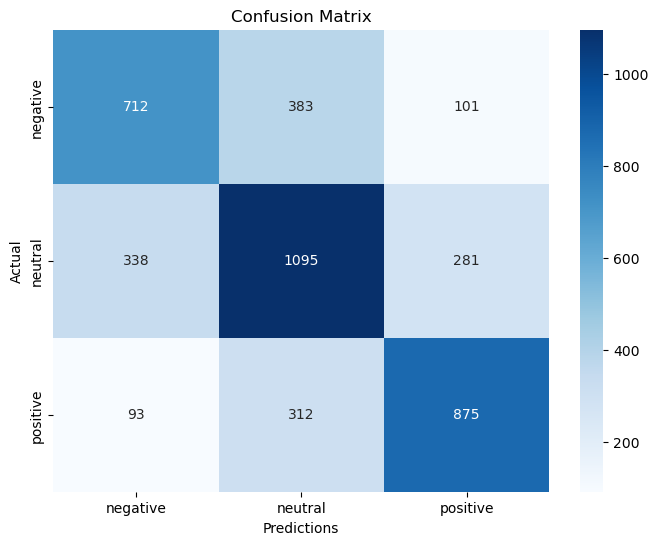

In [42]:
# Plot model 1 results
preds_test = model(X_test_tensor).max(1)[1]
plot_confusion_matrix(Y_test_tensor.numpy(), preds_test.numpy(), le.classes_)

In [43]:
# Calculate f1-score, precision and recall of a given model
from sklearn.metrics import f1_score, precision_score, recall_score

def calculate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

In [45]:
# Print metrics for model 1
calculate_metrics(Y_test_tensor.numpy(), preds_test.numpy())

F1 Score: 0.6402
Precision: 0.6407
Recall: 0.6401
Accuracy: 0.6401


In [46]:
# Function to display ROC curve
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_true, y_scores, classes):
    """Display the ROC curve for each class."""
    plt.figure(figsize=(10, 8))
    
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        plt.plot(fpr, tpr, label=f'ROC curve {class_name} (area = {auc(fpr, tpr):.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for each class')
    plt.legend(loc='lower right')
    plt.show()

In [47]:
# Function to display precision-recall curve
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_scores, classes):
    """Display the Precision-Recall curve for each class."""
    plt.figure(figsize=(10, 8))
    
    for i, class_name in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
        plt.plot(recall, precision, label=f'Precision-Recall curve {class_name}, area = {auc(recall, precision):.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for each class')
    plt.legend(loc='lower left')
    plt.show()

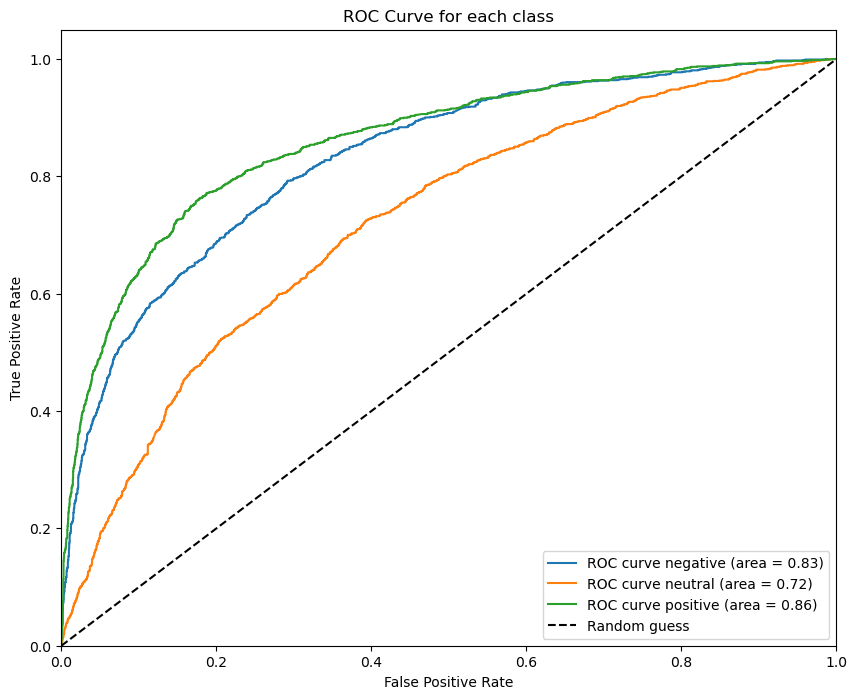

In [48]:
plot_roc_curve(Y_test_tensor.numpy(), model(X_test_tensor).detach().numpy(), le.classes_)

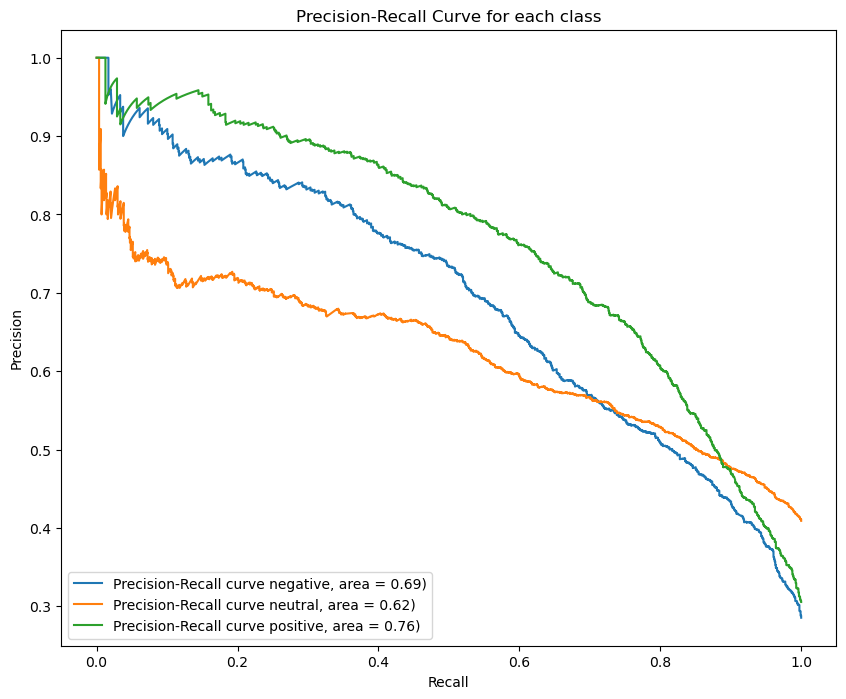

In [49]:
plot_precision_recall_curve(Y_test_tensor.numpy(), model(X_test_tensor).detach().numpy(), le.classes_)

# 8. (EXTRA for sentiment.py) 
Saving the vectorizer, label encoder and model for later use in the "sentiment.py" script

In [50]:
import joblib
import torch

# Save vectorizer and label encoder
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")

# Save model
torch.save(model.state_dict(), "model.pth")